In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import các thư viện cần thiết

In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import backend as K
import sklearn
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

#Create labels

In [ ]:
# System libraries
from pathlib import Path
import os.path
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-03-01 16:21:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-01 16:21:42 (66.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Walk through each directory
dataset = '/content/drive/MyDrive/nckh/data_100'

walk_through_dir(dataset)

In [ ]:
import pandas as pd
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.jpeg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
len(list(image_dir.glob(r'**/*.jpeg')))

42196

In [ ]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

# data aug

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 27600 validated image filenames belonging to 530 classes.
Found 6899 validated image filenames belonging to 530 classes.
Found 8625 validated image filenames belonging to 530 classes.


In [ ]:
# Resize Layer
from tensorflow.keras import layers,models
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(128,128),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "images_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint

early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 10,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.layers import Dense, Dropout , Softmax
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing



inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = Flatten()
x = Dense(2048, activation='relu')(pretrained_model.output) #relu
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(530, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        create_tensorboard_callback("training_logs",
                                    "images_classification"),
        checkpoint_callback,early_stopping
    ]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00366
Test Accuracy: 77.10%


In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

270/270 [==============================] - 41s 148ms/step
The first 5 predictions: ['Luke_Wilson', 'Nick_Frost', 'George_Lopez', 'Kellie_Martin', 'Sally_Field']


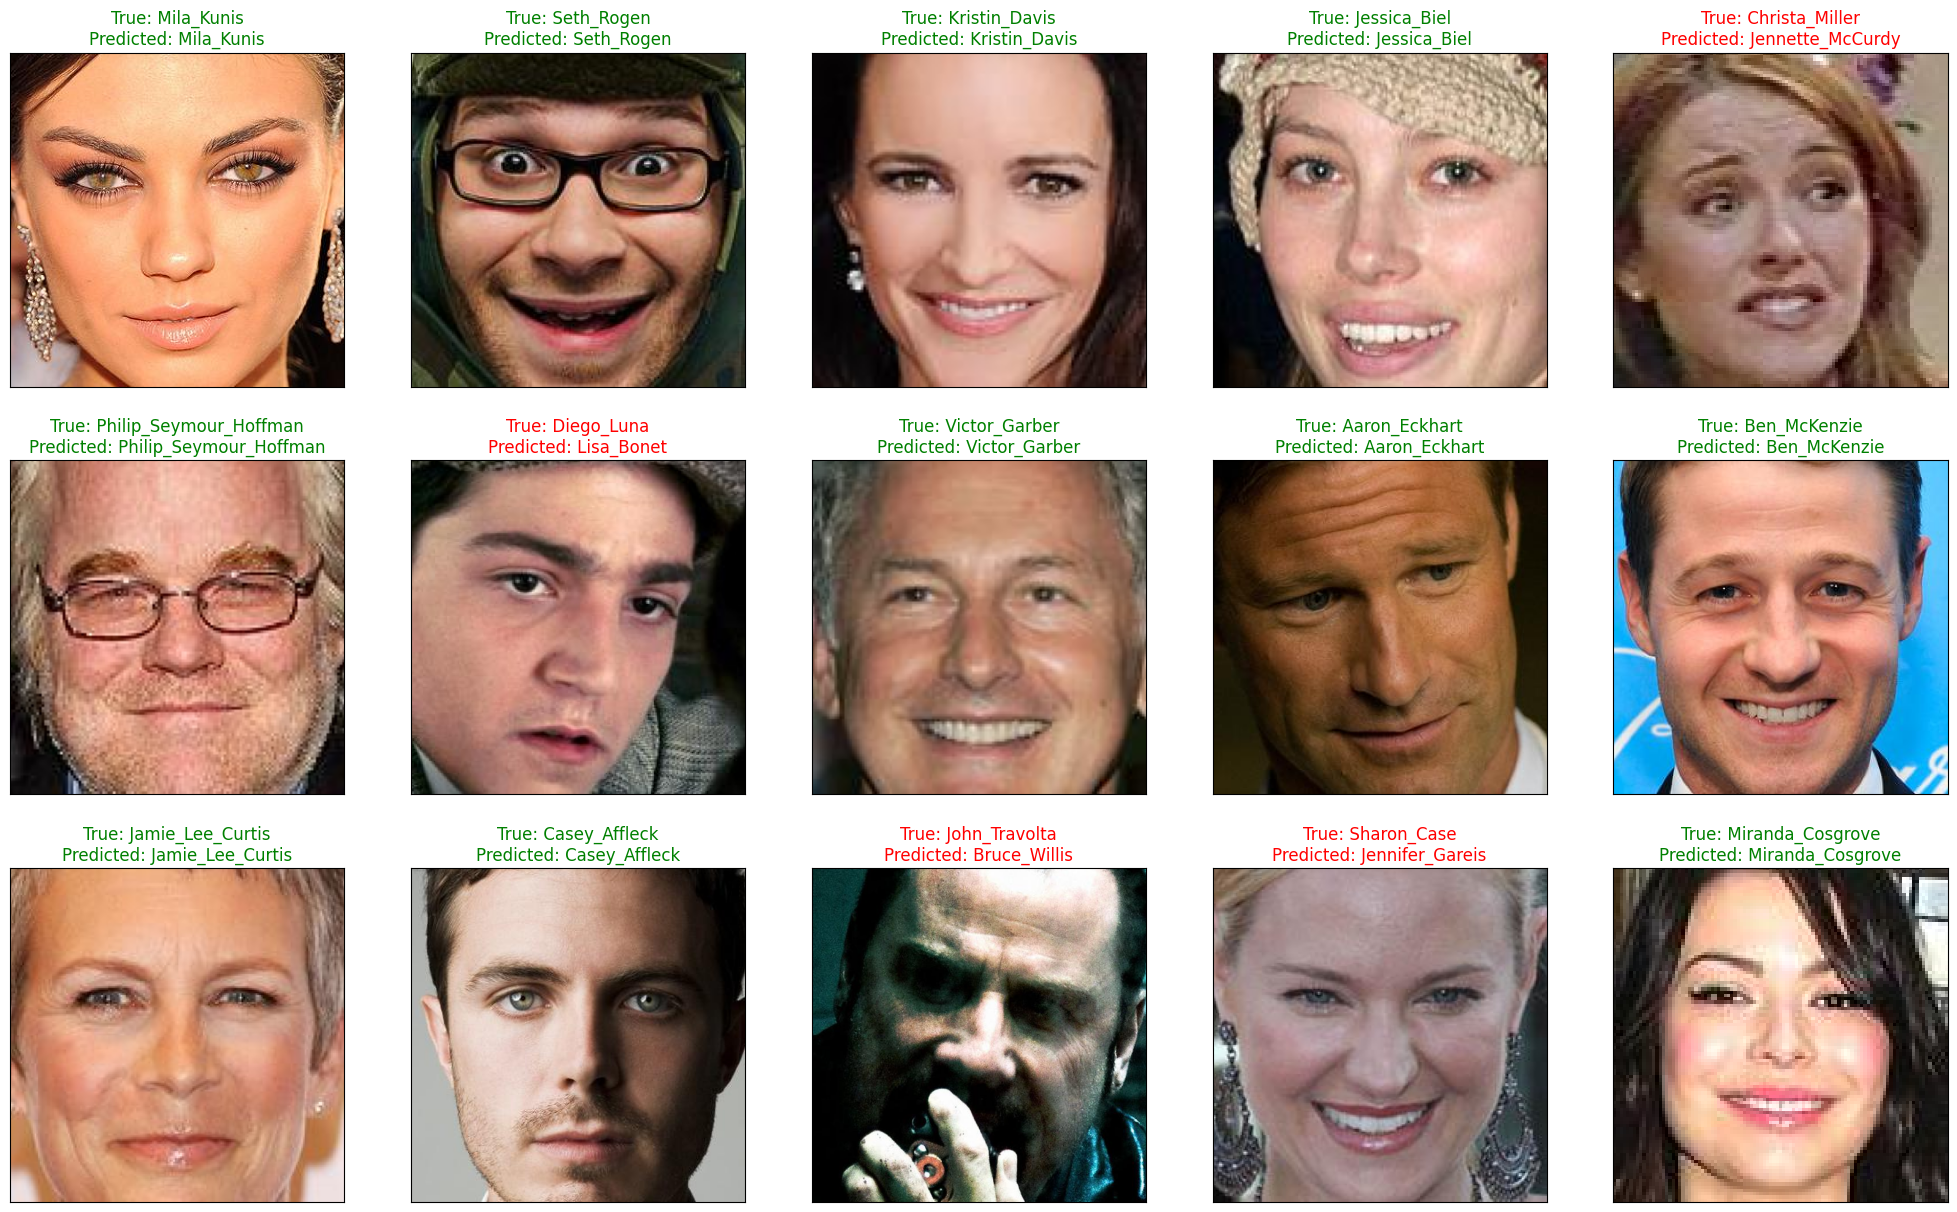

<Figure size 640x480 with 0 Axes>

In [ ]:
from PIL import Image

# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()


#Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# network parameters
sample      = 6000
image_size  = 128
input_shape = (image_size, image_size, 3)
batch_size  = 32
epochs      = 50
num_classes    = 530
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
                rescale=1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical'
)
# train_generator_inf = test_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(image_size, image_size),
#     batch_size=32,
#     class_mode='input'
# )
validation_generator = validation_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical'
)

Found 3179 images belonging to 530 classes.
Found 1060 images belonging to 530 classes.
Found 1060 images belonging to 530 classes.


# MobileNetV1

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Softmax
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam

class MobileNetV1(tf.keras.Model):
    def __init__(self, input_shape=(128, 128, 3), num_classes=530):
        super(MobileNetV1, self).__init__()

        self.mobilenet_base = tf.keras.applications.MobileNetV2(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet',
        )

        # self.flatten = Flatten()
        self.dense_1 = Dense(1024, activation='sigmoid')
        self.dropout_1 = Dropout(0.2)
        self.dense_2 = Dense(256, activation='sigmoid')  # Changed the name to dense_2
        self.dropout_2 = Dropout(0.2)
        self.dense_3 = Dense(64, activation='sigmoid')
        self.dropout_3 = Dropout(0.2)
        # self.dense_4 = Dense(64, activation='sigmoid')  # Changed the name to dense_4
        # self.dropout_4 = Dropout(0.5)
        self.output_layer = Dense(num_classes, activation='sigmoid')
        self.softmax = Softmax()



    def call(self, inputs):
        x = self.mobilenet_base(inputs)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.dropout_2(x)
        x = self.dense_3(x)
        x = self.dropout_3(x)
        # x = self.flatten(x)
        # x = self.dense_4(x)
        # x = self.dropout_4(x)
        x = self.output_layer(x)
        return self.softmax(x)


In [ ]:
model = MobileNetV1()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape = (None,128,128,3))
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobile_net_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  20972544  
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  262400    
                                                                 
 dropout_1 (Dropout)         multiple                  0

In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        create_tensorboard_callback("training_logs",
                                    "images_classification"),
        checkpoint_callback,early_stopping
    ]
)

In [ ]:
# sample_input, sample_target = next(iter(train_generator))
# sample_output = model.predict(sample_input)
# print("Sample Input Shape:", sample_input.shape)
# print("Sample Target Shape:", sample_target.shape)
# print("Sample Output Shape:", sample_output.shape)
